<h1 align="center">
    <img 
        src="../img/logo_white_bg.jpeg" 
        width="200" 
        border="1" />
</h1>
<h1 align="center">
    <b>GenAISHAP</b>
</h1>
<h4 align="center">
    <i>Explanations for Generative AI, LLM-and-SLM-Based, Solutions</i> ⚡️
</h4>



Generative AI SHAP (GAISHAP) is a python library that supports the creation of explanations to the metrics obtained for solutions based on LLMs (Large Language Models) or SLMs (Small Language Models). 

In summary, ***GenAISHAP*** works as follows:  ***GenAISHAP*** will create regression models, which we call them **black-box models**, for each of the metrics and will use those black-box models to produce explanations for each metric. The models are created from features extracted from the provided questions. Those **question features** could be generated automatically, using a tool, named **Featurizer** incorporated in the library or they can be manually created.

The previous notebooks showed an example of how to:

1. create the **Input** for ***GenAISHAP***, which is a simple Pandas DataFrame with the evaluation dataset with the `user_input` column and numerical columns that defines the generative AI metrics to create explanations.
2. The next notebook showed how to use the **Featurizer** tool to automatically create the characteristics of the user inputs that are going to be used as regressors of the black-models that are going to be used to create the explainers.

This notebook shows an example of how to create and use the explainers created on top of the user inputs and the features created in the previous notebooks. The following are the steps, that need to be done:

- Feature engineering
- Regression black-box model training
- Creation of SHAP explainers


In [1]:
import pandas as pd
from genaishap import GenAIExplainer
import shap
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
shap.initjs()

# 1. Load test and features

The following cell loads the pandas dataframes related to the test dataset and features created in the previous steps. And shows a single view of all the data.

In [3]:
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_features = pd.read_json('./test-features.json', orient='records')
df_test_dataset.join(df_features)

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question,there_is_any_initiative_or_program_identified_in_the_question,list_of_initiatives_or_programs_identified_in_the_question,there_is_any_financial_or_environmental_metric_identified_in_the_question,list_of_financial_or_environmental_metrics_identified_in_the_question,there_is_any_specific_year_identified_in_the_question,list_of_years_identified_in_the_question,is_a_question_about_trends_or_changes_over_time,is_a_question_about_identification_of_factors_or_insights,is_a_question_related_to_a_specific_page_or_section_of_a_document,is_a_question_about_goals_or_targets
0,Can you provide for me the three highlights fo...,"[31. In 2018, to align with industry best prac...",The three highlights for the GHG emissions sec...,"Sure, they are: \n1. 65% cumulative GHG emissi...",1.000000,0.0,0.000000,False,[],True,[Advancing Carbon-Free Energy],True,[GHG emissions],False,[],False,True,True,False
1,What percentage of waste from Google's offices...,[Performance highlights\nThe following section...,"In 2021, 78% of waste from Google's global dat...",Sixty-four percent.,1.000000,0.0,0.000000,True,[Google],False,[],True,[waste diversion],True,[2021],False,False,False,False
2,Can you present me with the performance highli...,"[Education\nFor more than 40 years, we’ve work...",The performance highlights for empowering user...,Sure! The Performance Highlights for Empowerin...,1.000000,0.0,0.000000,False,[],True,[Empowering Users With Technology],False,[],False,[],False,True,True,False
3,What was the listed key achievement regarding ...,[Our approach\nWe believe that every business ...,There is no listed key achievement for Google ...,"In 2017, Google became the first major company...",1.000000,1.0,1.000000,True,[Google],False,[],True,"[sustainability, climate change]",True,[2077],False,True,False,True
4,Did Google reach its intended Waste target und...,[BUILDING BETTER DEVICES AND SERVICES\nTarget ...,"Yes, in 2021, Google achieved the UL 2799 Zero...","No, this target has not been met in 2021. Howe...",0.666667,1.0,1.000000,True,[Google],True,[Building Better Devices and Services],True,[waste target],True,[2021],False,False,False,True
5,How many EV charging locations were there on G...,[This guidance does not recognize existing ren...,The provided context does not specify the numb...,200000,1.000000,0.0,0.000000,True,[Google],False,[],True,[EV charging locations],True,[2021],False,False,False,False
6,On what page of the report can I find the perf...,"[Employee Recruitment, Inclusion and Performan...",The performance highlights for the Empowering ...,The performance highlights for Empowering User...,0.000000,0.0,0.000000,False,[],True,[Empowering Users With Technology],False,[],False,[],False,False,True,False
7,Can you please provide for me the glossary of ...,[GRI INDEX\nGRI 304 - Biodiversity\nGRI 103 Ma...,I'm unable to provide the glossary of the docu...,"Sure, here is the glossary:\nGlossary\nCFE: ca...",0.500000,0.0,0.000000,False,[],False,[],False,[],False,[],False,False,True,False
8,On what page can I find details about Amazons ...,[IntroductionSustainability\nDriving Climate S...,You can find details about Amazon's climate so...,You can find information on driving climate so...,0.000000,0.0,0.000000,True,[Amazon],True,[Climate solutions],False,[],False,[],False,False,True,False
9,"For the listed Renewable Energy goals, by when...",[IntroductionSustainability\nDriving Climate S...,Amazon intends to have all operations powered ...,Amazon set the goal of becoming powered by 100...,1.000000,1.0,0.000000,True,[Amazon],True,[Renewable Energy goals],True,[100% renewable energy],False,[],False,False,False,True


# 2. Initialize the GenAI Explainer object

The following cell just initializes and checks consistency of the data to be used to create the explainers

In [4]:
genai_explainer = GenAIExplainer.from_pandas(df_test_dataset, df_features)

# 3. Feature engineering

All the columns in the `df_feature` dataframe are pre-processed as follows:

1. All the **boolean** features are mapped to a numerical feature of 0s and 1s.
2. All the **list of string** features are mapped to a one-hot-vector matrix.
3. All the features with zero variance are removed.

The following cell executes the feature engineering and shows the final X that will be used to train the black-box models

In [5]:
genai_explainer.feature_engineering()
X = pd.DataFrame(genai_explainer.preprocessed_features)
pd.DataFrame(genai_explainer.metrics).join(X)

,faithfulness,context_precision,context_recall,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question__microsoft,list_of_companies_identified_in_the_question__google,list_of_companies_identified_in_the_question__facebook,list_of_companies_identified_in_the_question__amazon,list_of_companies_identified_in_the_question__apple,list_of_companies_identified_in_the_question__meta,...,list_of_years_identified_in_the_question__2021,list_of_years_identified_in_the_question__2019,list_of_years_identified_in_the_question__2015,list_of_years_identified_in_the_question__2017,list_of_years_identified_in_the_question__2022,list_of_years_identified_in_the_question__2018,is_a_question_about_trends_or_changes_over_time,is_a_question_about_identification_of_factors_or_insights,is_a_question_related_to_a_specific_page_or_section_of_a_document,is_a_question_about_goals_or_targets
0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.000000,1.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.666667,1.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.000000,1.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 4. Training and validation of the black-box models

The training uses a local AutoML and a Hyperparameter tuning tool to calculate the best model to fit each metric.

> During the training and selection of the best models a **t-test** is performed to evaluate if the estimated metric using the models produces a statistically related sample from the same population of the original metric: fail to reject the null hypothesis that both, the original metric and the estimated metric are samples from the same population. If the t-test rejects the null hypothesis a warning message is displayed during the creation of the explainers.  The explainers cannot be used as reference. 


In [6]:
genai_explainer.create_explainers()

Metric loop:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:281: UserWarning: The best estimator for metric faithfulness is producing results that differs significantly with respect to the original metrics. This could lead to produce misleading explanations. Please change the features used to train the black-box model.
  warnings.warn(
/workspace/src/genaishap/explainer.py:298: UserWarning: There are 8 estimated values in the metric faithfulness far from the original values. The following is the list of indexes [7, 24, 25, 26, 27, 36, 37, 40].
  warnings.warn(


context_precision:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:298: UserWarning: There are 4 estimated values in the metric context_precision far from the original values. The following is the list of indexes [24, 25, 26, 41].
  warnings.warn(


context_recall:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:298: UserWarning: There are 6 estimated values in the metric context_recall far from the original values. The following is the list of indexes [24, 25, 26, 27, 31, 41].
  warnings.warn(


In [7]:
genai_explainer.r2_scores_

{'faithfulness': 0.7337578997527913,
 'context_precision': 0.8464959782474135,
 'context_recall': 0.8202125969617735}

> Also, as a rule of thumb, if the `r2_score` is high (>0.75) the explanations of black-box model could be used as reference. If it is lower, the use of the explainers could produce misleading conclusions.

Just as an example, let's use **context_recall** for now.  It is possible, at this point to generate explanations at the full dataset level to answer questions like: *What are the more relevant features of the questions that drives a higher, or lower **context_recall**?*

# 5. Dataset level explainers

In [8]:
metric = 'context_recall'

X = pd.DataFrame(genai_explainer.preprocessed_features)
metric_explainer = genai_explainer.explainers_[metric]
shap_values = metric_explainer(X)

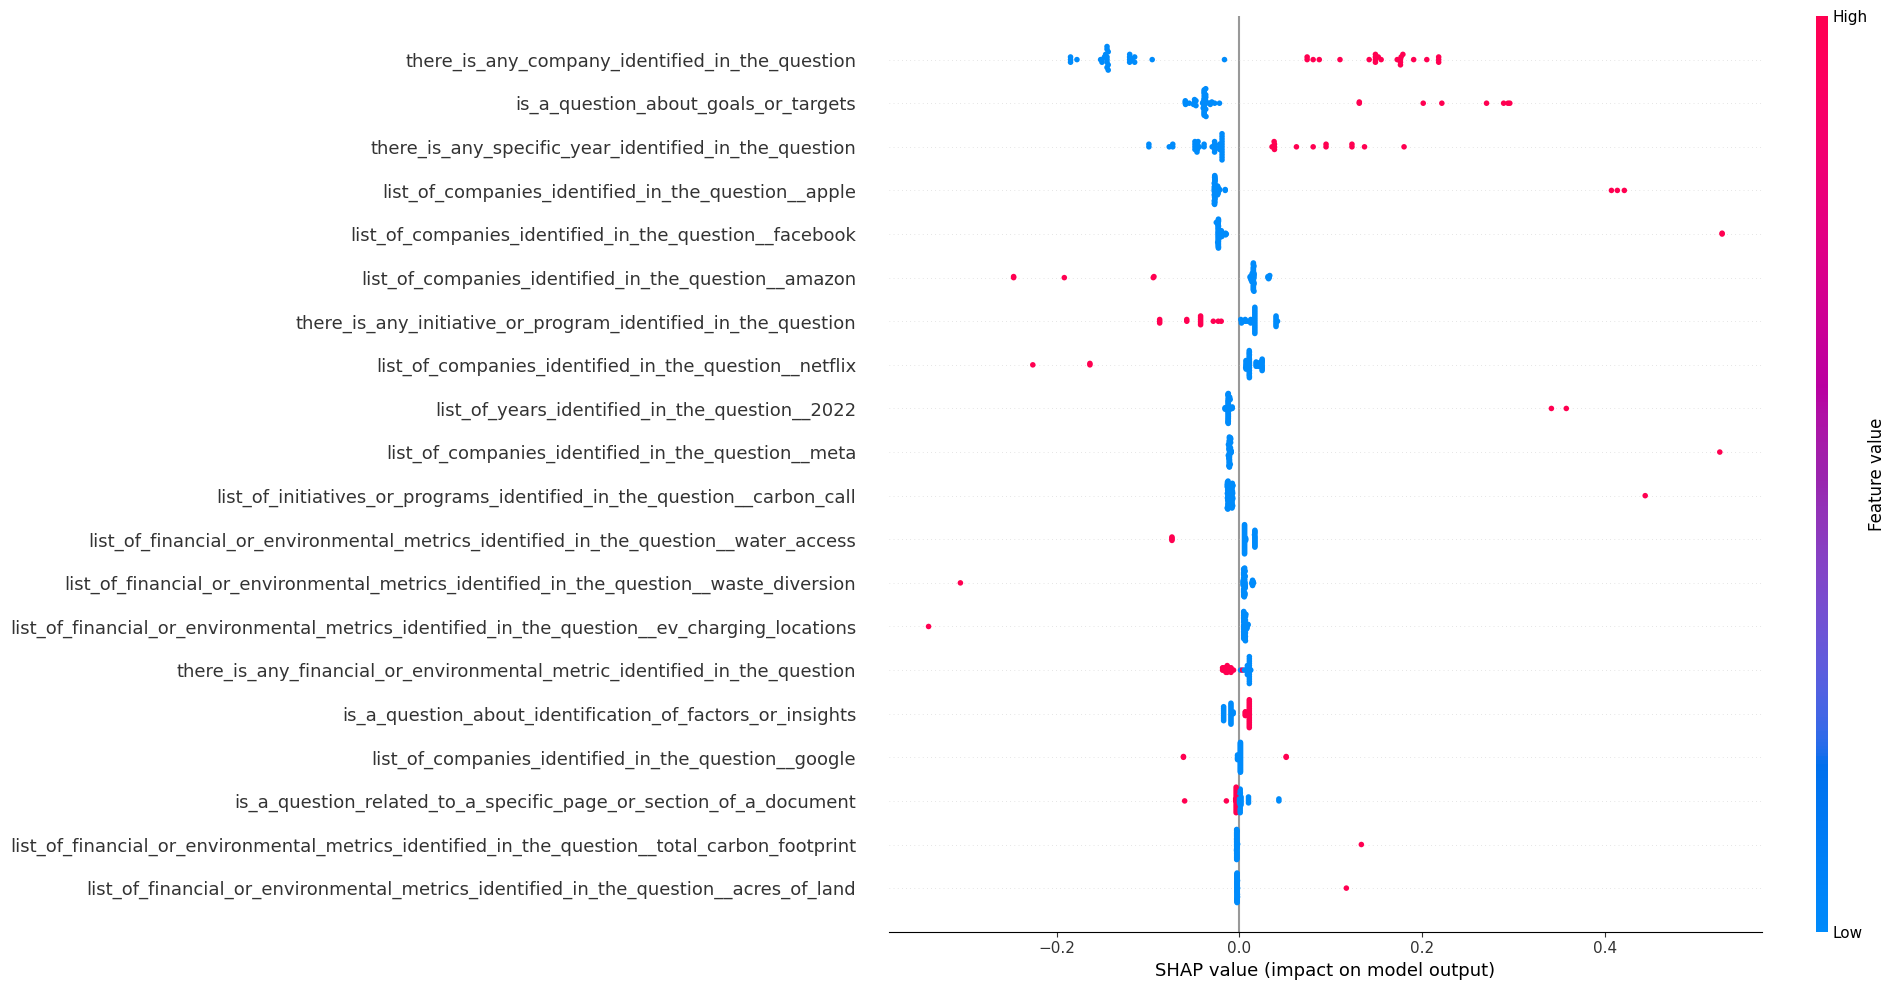

In [9]:
shap.summary_plot(shap_values, X, plot_size=(20,10))

> From this plot we can conclude, for example, that the **context recall**:
> - Is higher when there is a company identified in the question.
> - Also is higher when the question is about goals about goals and targets.
> - Also, we can conclude that the **context recall** is lower in the questions with explicit reference to Amazon, in contrast with the questions with explicit reference to Apple or Facebook. 
> 
> This type of information can be used as insights to guide next steps to improve the overall **context recall** of the solution.

# 6. Instance level explainers

During the creation of the explainers other warnings related to the safe use of the explainers can be raised. For example warinings like the following can be risen when creating the explainers for the **context recall** metric:

> `UserWarning: There are 6 estimated values in the metric context_recall far from the original values. The following is the list of indexes [24, 25, 26, 27, 31, 41].`

These warnings are shown because during the creation of the training of the black-box model to create the explainers, there is a process to evaluate how far are the estimated values of each metric compared to the original one, using t-distribution and confidence intervals.  If an instance is out of the confidence interval it is marked as too far from the original value and the warning is shown to alert the user to use carefully the instance explanations for those specific instances.

The following table shows a comparison of the original metric values compared with the estimated values calculated using the black-box model, and the identification if the instance is **out of range** and therefore the explanations should be used carefully for those instances.


In [10]:
df_metric = pd.DataFrame(genai_explainer.metrics)[[metric]]
df_metric['estimated_value'] = genai_explainer.estimators_[metric].predict(X)
df_metric['is_out_of_range'] = genai_explainer.is_out_of_range_[metric]

df_metric.style.apply(
    lambda s : [
        'background-color: yellow' if s.loc['is_out_of_range'] else '' for v in s.index
    ], axis=1)

,context_recall,estimated_value,is_out_of_range
0,0.000000,-0.003086,False
1,0.000000,0.020316,False
2,0.000000,0.034212,False
3,1.000000,0.961421,False
4,1.000000,0.964170,False
5,0.000000,0.027080,False
6,0.000000,-0.000147,False
7,0.000000,0.042708,False
8,0.000000,0.011980,False
9,0.000000,0.020118,False


As an example let's pick the 14th index, which has a **context recall** of 0, and an extimated value of 0.001. The following are the details of that instance:

In [13]:
index = 14

context = df_test_dataset.loc[index,'retrieved_contexts']
context_str = "\n".join([f"\n**CHUNK {i+1}:**\n\n{c}" for i, c in zip(range(len(context)),context)])


index_details = f"""
### INDEX {index}

**USER INPUT:**
{df_test_dataset.loc[index,'user_input']}

**RETRIEVED CONTEXT:**

{context_str}

**RESPONSE:**
{df_test_dataset.loc[index,'response']}

**REFERENCE:**
{df_test_dataset.loc[index,'reference']}

**METRIC:** {metric}

**METRIC Value:** {df_test_dataset.loc[index, metric]:.3f}

**MODEL ESTIMATED Value:** {df_metric.loc[index, 'estimated_value']:.3f}
"""

display(Markdown(index_details))


### INDEX 14

**USER INPUT:**
What household brands were featured in the in the climate pledge infographic on page 14?

**RETRIEVED CONTEXT:**


**CHUNK 1:**

Customer Shopping Experience
We have enabled 19 shopping features, such as new search 
functions and clearer digital badges, to highlight Climate 
Pledge Friendly products. These features have helped Amazon 
customers switch to a Climate Pledge Friendly product—
something that occurs the first time customers purchase a 
Climate Pledge Friendly product in a category for which they 
have only purchased non-Climate Pledge Friendly products 
over the prior two-year period. Customers can now shop 
for products across Apparel, Home, Electronics, and Kitchen 
categories, meaning customers now have access to 550,000 
Climate Pledge Friendly products, up from 250,000 in 2021. 
We have also seen strong adoption of the Climate Pledge 
Friendly program from Amazon Business customers. Amazon 
Business helps companies create guided buying policies, which 
place preference on sustainable products qualified through 
the Climate Pledge Friendly program. As of December 2022, 
18,000 businesses had these buying policies in place. 
 Climate Pledge Friendly product badge on Amazon.com. 
53
2022 Amazon Sustainability Report Introduction PeopleAppendixSustainability
Innovating Our Products and Services | Product Sustainability
O2

**CHUNK 2:**

As of December 2022, 
18,000 businesses had these buying policies in place. 
Looking Forward 
We are committed to continually improving product 
sustainability, enhancing responsible materials and 
commodities sourcing, and collaborating with supply chain 
partners to drive adoption of new regulations and compliance 
requirements. To promote responsible sourcing practices more 
widely, we will continue to advocate for robust standards 
that limit negative social and environmental impacts. We will 
also continue to improve device efficiency while delivering 
new and better ways for customers to shop for more-
sustainable products. 
Climate Pledge Friendly product badge on Amazon.com. 
Sustainable  
Product Selection
We aim to provide customers with more-sustainable 
alternatives throughout their shopping experience, offering 
them products with improvements in at least one sustainability 
area. Amazon’s flagship sustainable shopping program, Climate 
Pledge Friendly, is how we do this. 
Looking Forward
We are committed to continually improving product 
sustainability, enhancing responsible materials and 
commodities sourcing, and collaborating with supply chain 
partners to drive adoption of new regulations and compliance 
requirements. To promote responsible sourcing practices more 
widely, we will continue to advocate for robust standards 
that limit negative social and environmental impacts. We will 
also continue to improve device efficiency while delivering 
new and better ways for customers to shop for more-
sustainable products.
Climate Pledge Friendly 
Product Certification
As of December 2022, the Climate Pledge Friendly program 
added 16 certifications, giving selling partners 52 ways to 
qualify for Climate Pledge Friendly. The new certifications 
recognize improvements in at least one aspect of sustainability, 
from recycled content to energy efficiency. This year’s additions 
include, but are not limited to: 
• EU Energy Label grades A and B
• U.S. Environmental Protection Agency (EPA) Design for the 
Environment and WaterSense
• Fairtrade International
• NATRUE
• STANDARD 100 by OEKO-TEX
• Business + Institutional Furniture Manufacturers 
Association Level
• GreenCircle 
Device Certifications
We partner with trusted, transparent external certifications 
to validate the sustainability of our products and clearly 
communicate this to customers through the Climate Pledge 
Friendly badge. Since 2020, many of our Echo, Fire TV, 
Fire tablet, Kindle e-reader, and smart home devices and 
accessories have received sustainability certifications included 
in the Climate Pledge Friendly program. Many of these 
products qualified for the Climate Pledge Friendly badge by 
achieving the Carbon Trust’s Reducing C  certification, which 
highlights products with an associated carbon footprint that is 
decreasing annually. 
The Amazon Smart Thermostat is the first Amazon device 
to be ECOLOGO Silver certified, demonstrating it meets 
standards for reducing environmental impacts at one or more 
product lifecycle stages. To further reduce the thermostat’s 
environmental impact, we have also now introduced a new 
carbon-emissions-optimization feature. By monitoring 
local grid emissions data in real time, the thermostat can 
automatically adjust set temperature points to reduce energy 
use during high-emission periods, such as when grids are using 
less sustainable power sources. 
Learn more about device energy efficiency .
Climate Pledge Friendly also highlights products designed 
for circularity. Today, customers can choose from 20,000 
refurbished products through Pre-Owned Certified, a new 
certification recognizing products that are inspected, cleaned, 
and repaired to excellent functional standards. Pre-Owned 
Certified aims to extend the life of products, reducing 
e-waste and raw material extraction. The inclusion of Pre-
Owned Certified highlights the value we place on product 
reuse and circularity, giving customers access to high-quality 
refurbished electronics.
Customer Shopping Experience
We have enabled 19 shopping features, such as new search 
functions and clearer digital badges, to highlight Climate 
Pledge Friendly products. These features have helped Amazon 
customers switch to a Climate Pledge Friendly product—
something that occurs the first time customers purchase a 
Climate Pledge Friendly product in a category for which they 
have only purchased non-Climate Pledge Friendly products 
over the prior two-year period. Customers can now shop 
for products across Apparel, Home, Electronics, and Kitchen 
categories, meaning customers now have access to 550,000 
Climate Pledge Friendly products, up from 250,000 in 2021. 
We have also seen strong adoption of the Climate Pledge 
Friendly program from Amazon Business customers. Amazon 
Business helps companies create guided buying policies, which 
place preference on sustainable products qualified through 
the Climate Pledge Friendly program.

**RESPONSE:**
The context does not provide information about household brands featured in the climate pledge infographic on page 14.

**REFERENCE:**
Microsoft, jetBlue, Uber, Mercedez-Benz, Visa, IBM and Heineken

**METRIC:** context_recall

**METRIC Value:** 0.000

**MODEL ESTIMATED Value:** -0.000


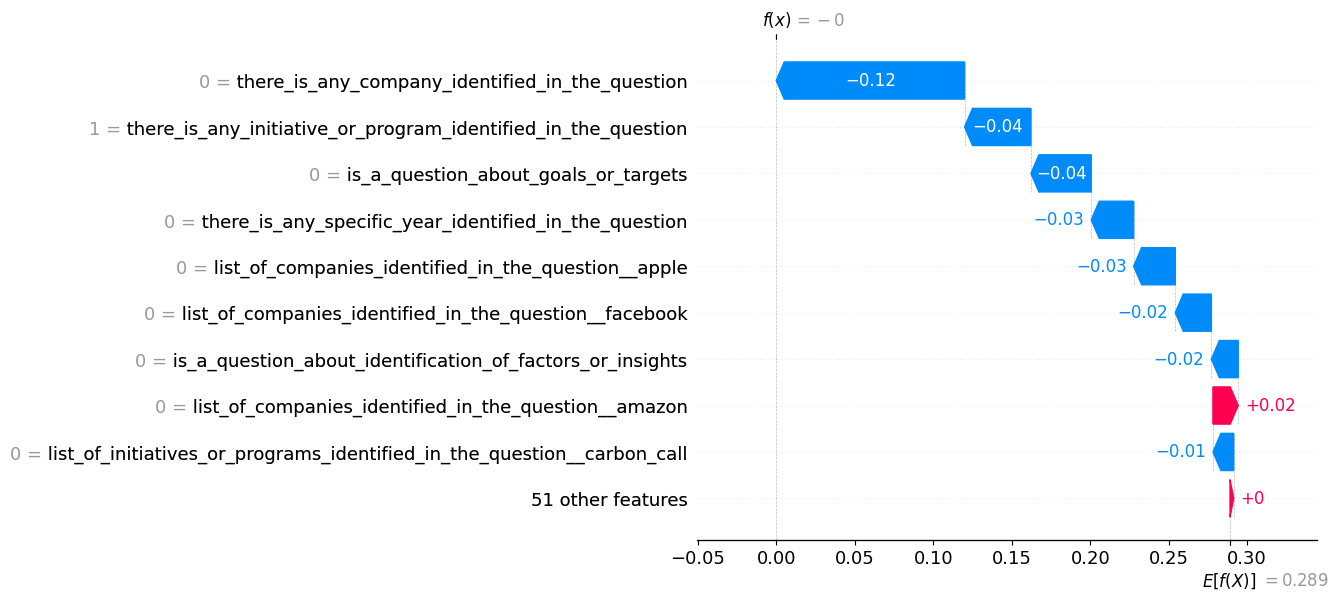

In [12]:
shap.waterfall_plot(shap_values[index])

> The horizontal axis of the SHAP waterfall plot shows the contributions of individual features to the model's prediction for a specific instance. The sum of all the contributions will be the final instance predicted value. 
>
> From this plot we can conclude that the reduction of the **context recall** for this specific instance was mainly driven by don't having an explicit mention of a company together with the mention of an specific initiative or program
> 
> This type of information add insights at the instance level on how to improve the overal quality of the solution.
